# Autism Prediction

## Introduction

The following notebook is based on the [Autism Prediction Kaggle competition](https://www.kaggle.com/competitions/autismdiagnosis/overview). As stated, the objective is to improve autism screening through machine learning and to create awareness among the data science community to develop an AI-based system for the early diagnosis of autism. It is relevant to mention that, nowadays, autism screening is both time-consuming and expensive, and Artificial Intelligence represents an opportunity to tackle this challenge.

The data collected is the result of applying a synthetic data creation algorithm to the dataset from [Autism Screening on Adults](https://www.kaggle.com/datasets/andrewmvd/autism-screening-on-adults), whose original source is a donation from researcher Fadi Thabtah to the Machine Learning Repository of UC Irvine ([UCI Machine Learning Repository: Autism Screening Adult](https://archive.ics.uci.edu/dataset/426/autism+screening+adult)) [1]. As you can imagine, the generation of synthetic data points caused some discrepancies that will be addressed below.

## About the dataset


The data contains answers from people who took the Autism Spectrum Quotient test on an [app](https://www.asdtests.com/) This test includes 10 questions and scores in a range from 0 to 10. If an individual scores 6 or above, it is suggested to visit a specialist for further assessment. The columns of the dataset are listed below:

* ID - ID of the patient
* A1_Score to A10_Score - Score based on Autism Spectrum Quotient (AQ) 10 item screening tool
* age - Age of the patient in years
* gender - Gender of the patient
* ethnicity - Ethnicity of the patient
* jaundice - Whether the patient had jaundice at the time of birth
* autism - Whether an immediate family member has been diagnosed with autism
* contry_of_res - Country of residence of the patient
* used_app_before - Whether the patient has undergone a screening test before
* result - Score for AQ1-10 screening test
* age_desc - Age of the patient
* relation - Relation of patient who completed the test
* Class/ASD - Classified result as 0 or 1. Here 0 represents No and 1 represents Yes. This is the target column, and during submission submit the values as 0 or 1 only.

Strangely, the synthetic data creation included individuals with scores above 6 but without an autism diagnosis, and vice versa. Moreover, if this test indicates a potential autism diagnosis after scoring 6 or more, then the only thing a predictor should do is sum the question points to classify an individual. AI is absolutely unnecessary. Although this discredits the purpose of the Kaggle competition referenced, this data could serve another research objective.

## Scope

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV,  cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, fbeta_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

import shap


C:\Users\PX976YU\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = pd.read_csv('Autism_Prediction/train.csv') 
test_data = pd.read_csv('Autism_Prediction/test.csv') 


# Exploratory Data Analysis

In [3]:
print("Train data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)

Train data shape:  (800, 22)
Test data shape:  (200, 21)


In [4]:
train_data.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


Data types and null values

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

In [6]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,800.0,400.500000,231.084400,1.000000,200.750000,400.500000,600.250000,800.000000
A1_Score,800.0,0.560000,0.496697,0.000000,0.000000,1.000000,1.000000,1.000000
A2_Score,800.0,0.530000,0.499411,0.000000,0.000000,1.000000,1.000000,1.000000
A3_Score,800.0,0.450000,0.497805,0.000000,0.000000,0.000000,1.000000,1.000000
A4_Score,800.0,0.415000,0.493030,0.000000,0.000000,0.000000,1.000000,1.000000
A5_Score,800.0,0.395000,0.489157,0.000000,0.000000,0.000000,1.000000,1.000000
A6_Score,800.0,0.303750,0.460164,0.000000,0.000000,0.000000,1.000000,1.000000
A7_Score,800.0,0.397500,0.489687,0.000000,0.000000,0.000000,1.000000,1.000000
A8_Score,800.0,0.508750,0.500236,0.000000,0.000000,1.000000,1.000000,1.000000
A9_Score,800.0,0.495000,0.500288,0.000000,0.000000,0.000000,1.000000,1.000000


In [7]:
def rename_columns(df):
    df = df.rename(columns = {'contry_of_res' : 'country_of_res', 'austim' : 'autism'})
    return df

In [8]:
train_data = rename_columns(train_data)
test_data = rename_columns(test_data)

What are the values of categorical variables?

In [9]:
for col in ['gender', 'ethnicity',
       'jaundice', 'autism', 'country_of_res',
       'used_app_before', 'age_desc', 'relation', 'Class/ASD']:
    print("-------------------------------")
    print(f'Column name: {col}\n')
    print(f'Number of unique values:\n{train_data[col].nunique()}')
    print(f'Unique values:\n{train_data[col].unique()}')

-------------------------------
Column name: gender

Number of unique values:
2
Unique values:
['f' 'm']
-------------------------------
Column name: ethnicity

Number of unique values:
12
Unique values:
['?' 'White-European' 'Middle Eastern ' 'Pasifika' 'Black' 'Others'
 'Hispanic' 'Asian' 'Turkish' 'South Asian' 'Latino' 'others']
-------------------------------
Column name: jaundice

Number of unique values:
2
Unique values:
['no' 'yes']
-------------------------------
Column name: autism

Number of unique values:
2
Unique values:
['no' 'yes']
-------------------------------
Column name: country_of_res

Number of unique values:
56
Unique values:
['Austria' 'India' 'United States' 'South Africa' 'Jordan'
 'United Kingdom' 'Brazil' 'New Zealand' 'Canada' 'Kazakhstan'
 'United Arab Emirates' 'Australia' 'Ukraine' 'Iraq' 'France' 'Malaysia'
 'Viet Nam' 'Egypt' 'Netherlands' 'Afghanistan' 'Oman' 'Italy'
 'AmericanSamoa' 'Bahamas' 'Saudi Arabia' 'Ireland' 'Aruba' 'Sri Lanka'
 'Russia' 'Bo

Which countries have the most records?

In [10]:
asd_by_country = train_data[['country_of_res', 'Class/ASD']].groupby('country_of_res').sum().reset_index()
asd_by_country['log Class/ASD'] = np.log1p(asd_by_country["Class/ASD"])

In [11]:
figmap = px.choropleth(asd_by_country, 
                    locations="country_of_res", 
                    locationmode='country names',
                    color='log Class/ASD', 
                    hover_name="country_of_res", 
                    hover_data = {"Class/ASD" : True, 'log Class/ASD' : False},
                    labels = {"Class/ASD" : "Autism cases"},
                    color_continuous_scale=px.colors.sequential.Peach,
                    projection='natural earth',
                    title="Sum of Class/ASD by Country")

figmap.update_coloraxes(colorbar = dict(tickvals = np.log1p([0,3,9,27,65]), ticktext = ['0', '3','9', '27', '69']), colorbar_title = "Autism cases")

In [12]:
figbar = px.bar(asd_by_country.sort_values('Class/ASD', ascending = False)[:10], x = 'country_of_res', y = 'Class/ASD', text = 'Class/ASD',
            color_discrete_sequence = ['#e25f25'], title = 'Top Countries with Autism cases',
            labels = {'Class/ASD' : 'Autism cases', 'country_of_res' : 'Country of residence'})
figbar.update_layout(showlegend = False)

Is the result enough for the diagnosis?

In [13]:
train_data['result'] = train_data.loc[:,'A1_Score':'A10_Score'].sum(axis=1)

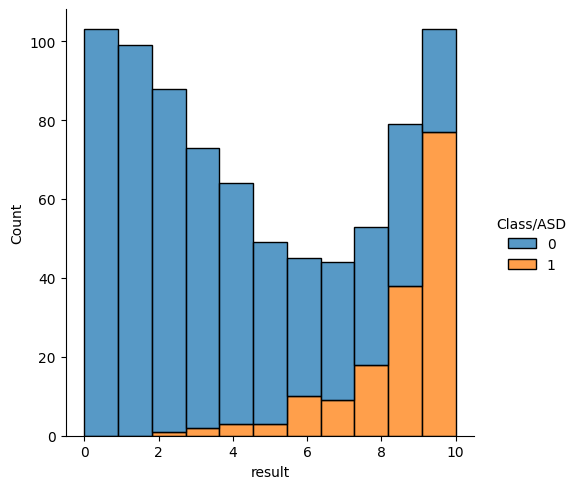

In [14]:
sns.displot(train_data, x="result", hue = 'Class/ASD', multiple = 'stack')

Age distribution

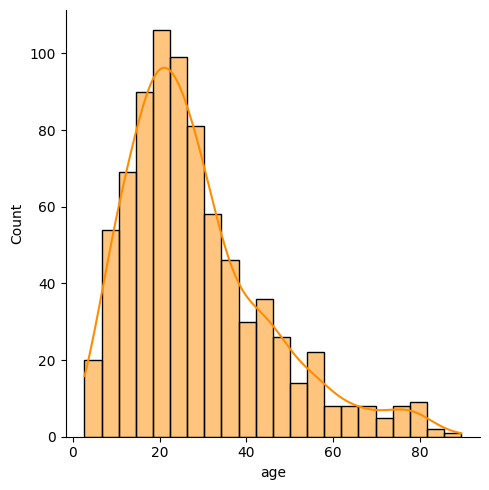

In [15]:
sns.displot(train_data['age'], kde = True, color = 'DarkOrange')

Ethnicity distribution

<Axes: xlabel='count', ylabel='ethnicity'>

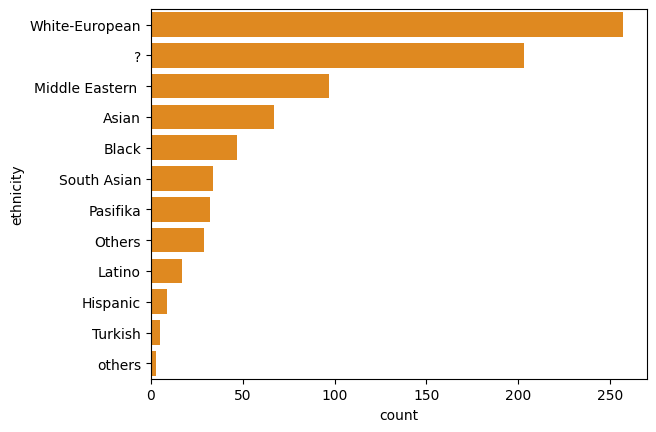

In [16]:
sns.countplot(train_data['ethnicity'], color = 'DarkOrange', order = train_data['ethnicity'].value_counts().index)

# Data preparation

In [17]:
def clean_data(df):
    #Remove records with age less than 18
    df['age'] = df['age'].astype(int)
    df = df[df['age']>=18]
    #Drop unnecesary columns
    df = df.drop(['ID', 'country_of_res', 'used_app_before', 'age_desc', 'relation', 'gender', 'result'], axis = 1)
    #Replace "others" with "Others" in ethnicity
    df['ethnicity'] = df['ethnicity'].replace("others", "Others")
    return df

In [18]:
train_data2 = clean_data(train_data)
test_data2 = clean_data(test_data)

print("train data shape: ", train_data2.shape)
print("test data shape: ", test_data2.shape)

train data shape:  (577, 15)
test data shape:  (133, 14)


In [19]:
train_data2.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,ethnicity,jaundice,autism,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38,?,no,no,0
1,0,0,0,0,0,0,0,0,0,0,47,?,no,no,0
3,0,0,0,0,0,0,0,0,0,0,23,?,no,no,0
4,0,0,0,0,0,0,0,0,0,0,43,?,no,no,0
5,1,0,0,0,0,1,0,0,1,1,31,Middle Eastern,no,no,0


In [20]:
def binarize(df):
    df['jaundice'] = df['jaundice'].replace({'no': 0, 'yes' : 1})
    df['autism'] = df['autism'].replace({'no': 0, 'yes' : 1})

    return df

In [21]:
def prepare_test_train(traindf, testdf):
    testdf = binarize(testdf)
    traindf = binarize(traindf)
    scaler = MinMaxScaler()

    traindf['age'] = scaler.fit_transform(traindf[['age']])
    testdf['age'] = scaler.transform(testdf[['age']])

    traindummies = pd.get_dummies(traindf, columns = ['ethnicity']).astype(int)
    testdummies = pd.get_dummies(testdf, columns = ['ethnicity']).astype(int)
    testdummies = testdummies.reindex(columns = traindummies.columns, fill_value = 0)

    return traindummies, testdummies

In [22]:
train_data3, test_data3 = prepare_test_train(train_data2, test_data2)

C:\Users\PX976YU\AppData\Local\Temp\ipykernel_30420\4163226426.py:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\PX976YU\AppData\Local\Temp\ipykernel_30420\4163226426.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [23]:
train_data3.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,ethnicity_Asian,ethnicity_Black,ethnicity_Hispanic,ethnicity_Latino,ethnicity_Middle Eastern,ethnicity_Others,ethnicity_Pasifika,ethnicity_South Asian,ethnicity_Turkish,ethnicity_White-European
0,1,0,1,0,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,1,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0


In [24]:
print("train data shape: ", train_data3.shape)
print("test data shape: ", test_data3.shape)

train data shape:  (577, 25)
test data shape:  (133, 25)


In [25]:
X = train_data3.drop(['Class/ASD'], axis = 1)
y = train_data3['Class/ASD'].reset_index(drop = True)

In [26]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

df_pca['ASD'] = y

In [27]:
# Plot the PCA results using Plotly
fig = px.scatter(df_pca, x='PC1', y='PC2', color=df_pca['ASD'].astype(str),
                 title='PCA of Dataset',
                 labels={'color': 'Class'},
                 color_discrete_map={'0': 'darkorange', '1': 'teal'})
fig.show()

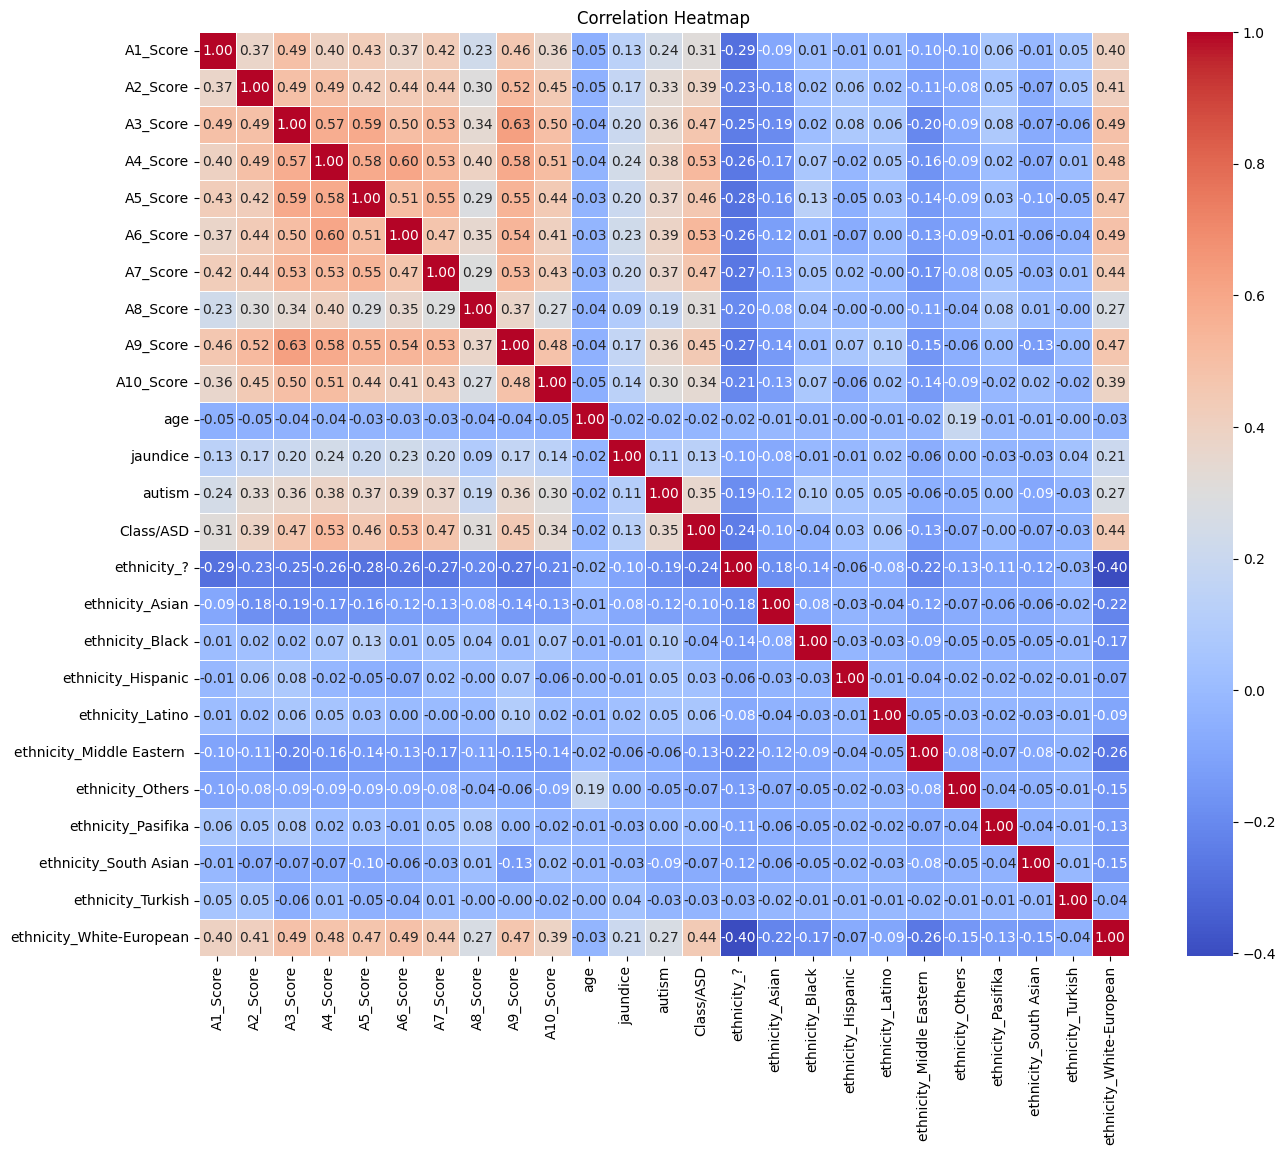

In [28]:
corr = train_data3.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Data modeling

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 21)

In [30]:
print("Records in training dataset: ", len(X_train))
print("Records in validation dataset: ", len(X_valid))

Records in training dataset:  461
Records in validation dataset:  116


## Class weight tuning 

### Logistic Regression

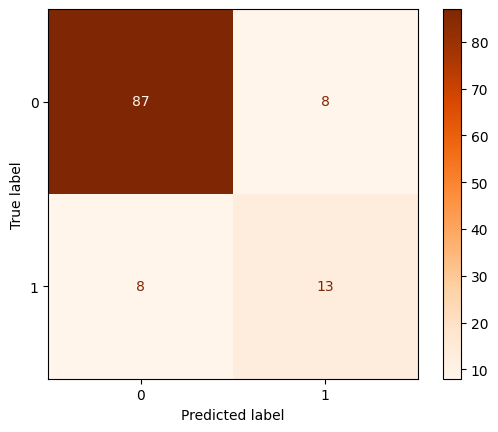

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        95
           1       0.62      0.62      0.62        21

    accuracy                           0.86       116
   macro avg       0.77      0.77      0.77       116
weighted avg       0.86      0.86      0.86       116

F2 Score: 0.62


In [31]:
model = LogisticRegression(max_iter = 150)

model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

cm= confusion_matrix(y_valid, y_pred)
class_report = classification_report(y_valid, y_pred)
f2_score = fbeta_score(y_valid, y_pred, beta=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()
print('Classification Report:')
print(class_report)
print(f'F2 Score: {round(f2_score,2)}')

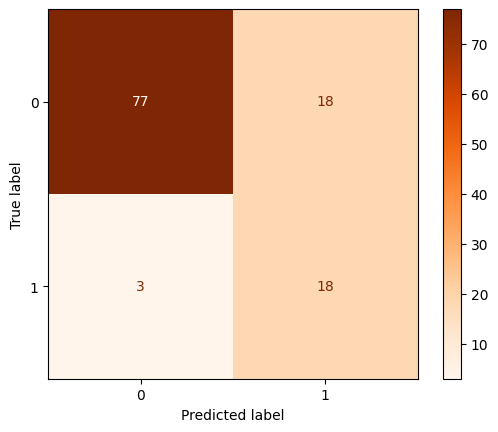

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88        95
           1       0.50      0.86      0.63        21

    accuracy                           0.82       116
   macro avg       0.73      0.83      0.76       116
weighted avg       0.88      0.82      0.84       116

F2 Score: 0.75


In [32]:
model = LogisticRegression(class_weight='balanced', max_iter = 150)

model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
class_report = classification_report(y_valid, y_pred)
f2_score = fbeta_score(y_valid, y_pred, beta=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()
print('Classification Report:')
print(class_report)
print(f'F2 Score: {round(f2_score,2)}')

### Random Forest

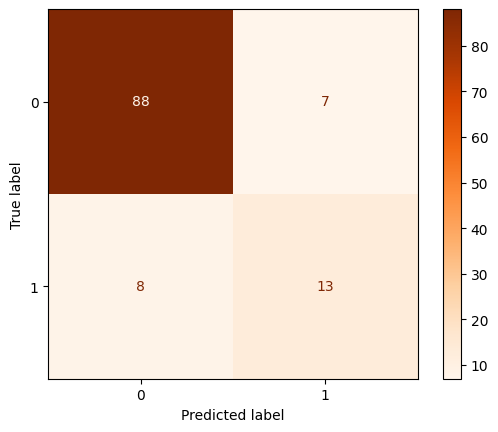

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92        95
           1       0.65      0.62      0.63        21

    accuracy                           0.87       116
   macro avg       0.78      0.77      0.78       116
weighted avg       0.87      0.87      0.87       116

F2 Score: 0.62


In [33]:
model = RandomForestClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

cm= confusion_matrix(y_valid, y_pred)
class_report = classification_report(y_valid, y_pred)
f2_score = fbeta_score(y_valid, y_pred, beta=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()
print('Classification Report:')
print(class_report)
print(f'F2 Score: {round(f2_score,2)}')

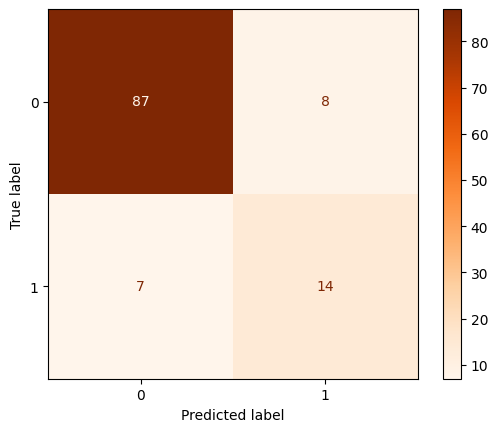

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92        95
           1       0.64      0.67      0.65        21

    accuracy                           0.87       116
   macro avg       0.78      0.79      0.79       116
weighted avg       0.87      0.87      0.87       116

F2 Score: 0.66


In [34]:
model = RandomForestClassifier(class_weight = 'balanced')

model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

cm= confusion_matrix(y_valid, y_pred)
class_report = classification_report(y_valid, y_pred)
f2_score = fbeta_score(y_valid, y_pred, beta=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()
print('Classification Report:')
print(class_report)
print(f'F2 Score: {round(f2_score,2)}')

### XGBoost

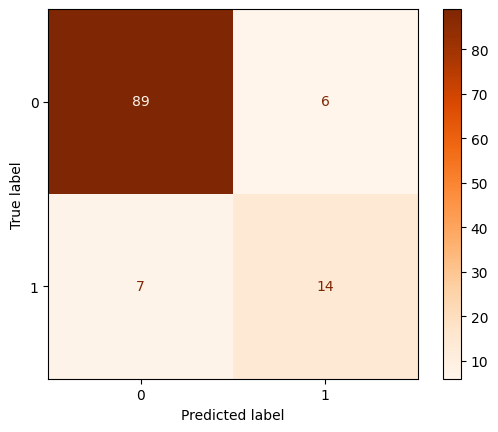

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93        95
           1       0.70      0.67      0.68        21

    accuracy                           0.89       116
   macro avg       0.81      0.80      0.81       116
weighted avg       0.89      0.89      0.89       116

F2 Score: 0.67


In [35]:
model = xgb.XGBClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

cm= confusion_matrix(y_valid, y_pred)
class_report = classification_report(y_valid, y_pred)
f2_score = fbeta_score(y_valid, y_pred, beta=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()
print('Classification Report:')
print(class_report)
print(f'F2 Score: {round(f2_score,2)}')

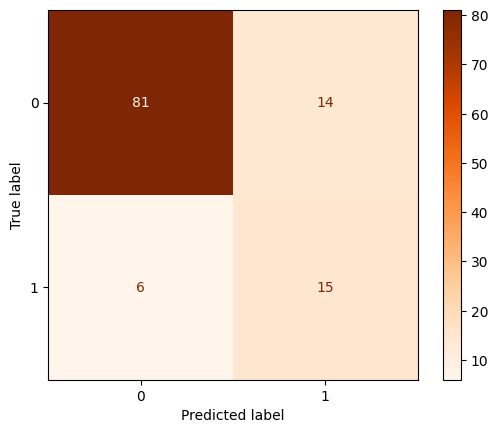

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89        95
           1       0.52      0.71      0.60        21

    accuracy                           0.83       116
   macro avg       0.72      0.78      0.75       116
weighted avg       0.86      0.83      0.84       116

F2 Score: 0.66


In [36]:
model = xgb.XGBClassifier(scale_pos_weight = 10)

model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

cm= confusion_matrix(y_valid, y_pred)
class_report = classification_report(y_valid, y_pred)
f2_score = fbeta_score(y_valid, y_pred, beta=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()
print('Classification Report:')
print(class_report)
print(f'F2 Score: {round(f2_score,2)}')

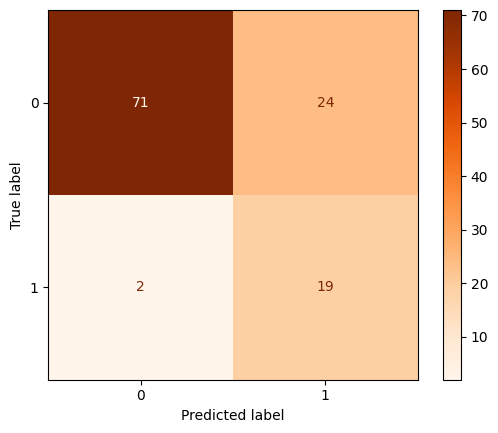

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.75      0.85        95
           1       0.44      0.90      0.59        21

    accuracy                           0.78       116
   macro avg       0.71      0.83      0.72       116
weighted avg       0.88      0.78      0.80       116

F2 Score: 0.75


In [37]:
model = xgb.XGBClassifier(scale_pos_weight = 10, learning_rate = 0.03)

model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

cm= confusion_matrix(y_valid, y_pred)
class_report = classification_report(y_valid, y_pred)
f2_score = fbeta_score(y_valid, y_pred, beta=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()
print('Classification Report:')
print(class_report)
print(f'F2 Score: {round(f2_score,2)}')

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'scale_pos_weight': 20, 'subsample': 0.8}
Best F2 Score (CV): 0.7918629162283229


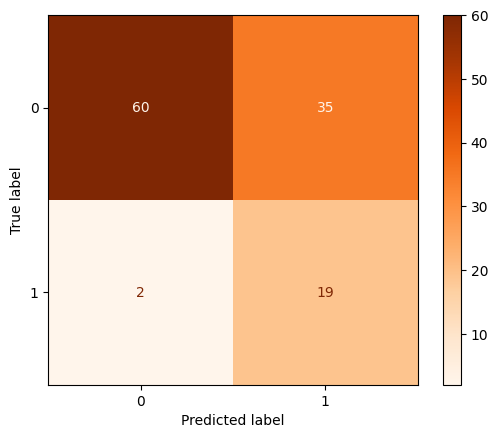

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.63      0.76        95
           1       0.35      0.90      0.51        21

    accuracy                           0.68       116
   macro avg       0.66      0.77      0.64       116
weighted avg       0.86      0.68      0.72       116



In [38]:
model = xgb.XGBClassifier()

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
    'scale_pos_weight': [3, 5, 10, 20, 100],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

f2_scorer = make_scorer(fbeta_score, beta=2)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=f2_scorer, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
class_report = classification_report(y_valid, y_pred)
f2_score = fbeta_score(y_valid, y_pred, beta=2)

print(f'Best Parameters: {best_params}')
print(f'Best F2 Score (CV): {best_score}')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()
print('Classification Report:')
print(class_report)

## Sampling techniques

### Undersampling

In [39]:
print(f'Class distribution: {Counter(y)}')

Class distribution: Counter({0: 453, 1: 124})


In [40]:
rus = RandomUnderSampler(random_state=21)

X_res, y_res = rus.fit_resample(X, y)

# Display new class distribution
print(f'Resampled class distribution: {Counter(y_res)}')

Resampled class distribution: Counter({0: 124, 1: 124})


In [41]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_res, y_res, test_size = 0.2, random_state = 21, stratify = y_res)
print("Records in training dataset: ", len(X_train2))
print("Records in validation dataset: ", len(X_valid2))

Records in training dataset:  198
Records in validation dataset:  50


#### Logistic Regression

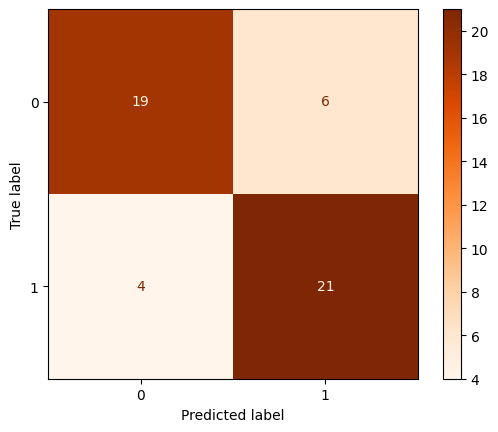

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        25
           1       0.78      0.84      0.81        25

    accuracy                           0.80        50
   macro avg       0.80      0.80      0.80        50
weighted avg       0.80      0.80      0.80        50

F2 Score: 0.83


In [42]:
model = LogisticRegression(class_weight='balanced', max_iter = 150)

model.fit(X_train2, y_train2)

y_pred = model.predict(X_valid2)

cm = confusion_matrix(y_valid2, y_pred)
class_report = classification_report(y_valid2, y_pred)
f2_score = fbeta_score(y_valid2, y_pred, beta=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()
print('Classification Report:')
print(class_report)
print(f'F2 Score: {round(f2_score,2)}')

#### XGBoost

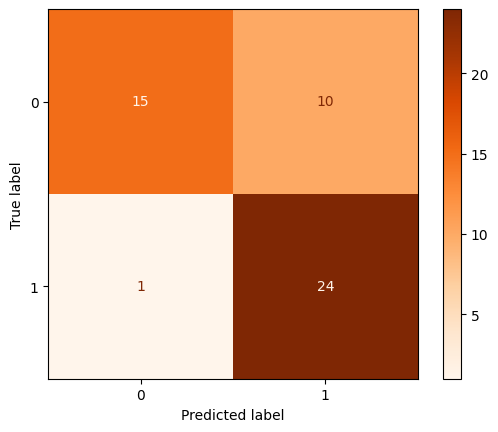

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.60      0.73        25
           1       0.71      0.96      0.81        25

    accuracy                           0.78        50
   macro avg       0.82      0.78      0.77        50
weighted avg       0.82      0.78      0.77        50

F2 Score: 0.9


In [43]:
model = xgb.XGBClassifier(scale_pos_weight = 10, learning_rate = 0.03)

model.fit(X_train2, y_train2)

y_pred = model.predict(X_valid2)

cm= confusion_matrix(y_valid2, y_pred)
class_report = classification_report(y_valid2, y_pred)
f2_score = fbeta_score(y_valid2, y_pred, beta=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()
print('Classification Report:')
print(class_report)
print(f'F2 Score: {round(f2_score,2)}')

In [44]:
model = xgb.XGBClassifier(scale_pos_weight=10, learning_rate=0.03)

cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=21)
f2_scores = cross_val_score(model, X_res, y_res, cv=cv, scoring=f2_scorer)

print('F2 Scores for each fold:', f2_scores)
print(f'Mean F2 Score: {np.mean(f2_scores):.2f}')

F2 Scores for each fold: [0.90909091 0.89147287 0.85185185 0.81300813 0.83333333]
Mean F2 Score: 0.86


### Oversampling (# majority class = # minority class)

In [45]:
print(f'Class distribution: {Counter(y)}')

Class distribution: Counter({0: 453, 1: 124})


In [46]:
ros = RandomOverSampler(random_state=21)

X_res2, y_res2 = ros.fit_resample(X, y)

# Display new class distribution
print(f'Resampled class distribution: {Counter(y_res2)}')

Resampled class distribution: Counter({0: 453, 1: 453})


In [47]:
X_train3, X_valid3, y_train3, y_valid3 = train_test_split(X_res2, y_res2, test_size = 0.2, random_state = 21, stratify = y_res2)
print("Records in training dataset: ", len(X_train3))
print("Records in validation dataset: ", len(X_valid3))

Records in training dataset:  724
Records in validation dataset:  182


#### Logistic Regression

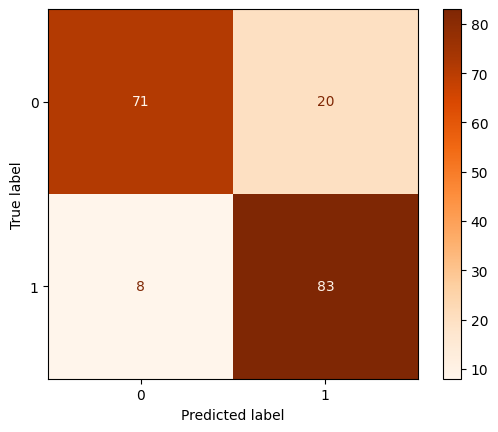

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.78      0.84        91
           1       0.81      0.91      0.86        91

    accuracy                           0.85       182
   macro avg       0.85      0.85      0.85       182
weighted avg       0.85      0.85      0.85       182

F2 Score: 0.89


In [48]:
model = LogisticRegression(class_weight='balanced', max_iter = 150)

model.fit(X_train3, y_train3)

y_pred = model.predict(X_valid3)

cm = confusion_matrix(y_valid3, y_pred)
class_report = classification_report(y_valid3, y_pred)
f2_score = fbeta_score(y_valid3, y_pred, beta=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()
print('Classification Report:')
print(class_report)
print(f'F2 Score: {round(f2_score,2)}')

#### XGBoost

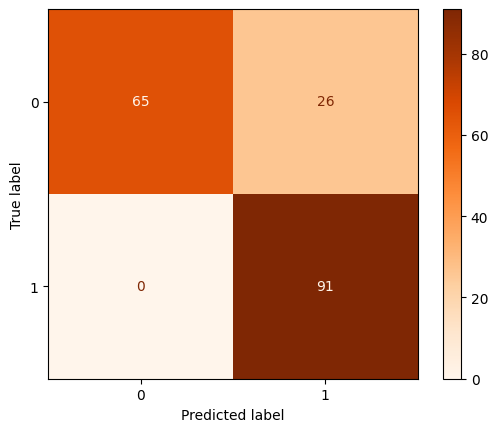

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83        91
           1       0.78      1.00      0.88        91

    accuracy                           0.86       182
   macro avg       0.89      0.86      0.85       182
weighted avg       0.89      0.86      0.85       182

F2 Score: 0.95


In [49]:
model = xgb.XGBClassifier(scale_pos_weight = 10, learning_rate = 0.03)

model.fit(X_train3, y_train3)

y_pred = model.predict(X_valid3)

cm= confusion_matrix(y_valid3, y_pred)
class_report = classification_report(y_valid3, y_pred)
f2_score = fbeta_score(y_valid3, y_pred, beta=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()
print('Classification Report:')
print(class_report)
print(f'F2 Score: {round(f2_score,2)}')

In [50]:
model = xgb.XGBClassifier(scale_pos_weight=10, learning_rate=0.03)

cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=21)
f2_scores = cross_val_score(model, X_res2, y_res2, cv=cv, scoring=f2_scorer)

print('F2 Scores for each fold:', f2_scores)
print(f'Mean F2 Score: {np.mean(f2_scores):.2f}')

F2 Scores for each fold: [0.96602972 0.93220339 0.94537815 0.94594595 0.94989562]
Mean F2 Score: 0.95


### Oversampling (2 * # minority class)

In [51]:
minority_class_count = Counter(y)[1]
desired_minority_class_count = minority_class_count * 2

sampling_strategy = {0: Counter(y)[0], 1: desired_minority_class_count}

ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=21)

X_res3, y_res3 = ros.fit_resample(X, y)

print(f'Resampled class distribution: {Counter(y_res3)}')

Resampled class distribution: Counter({0: 453, 1: 248})


In [52]:
X_train4, X_valid4, y_train4, y_valid4 = train_test_split(X_res3, y_res3, test_size = 0.2, random_state = 21, stratify = y_res3)
print("Records in training dataset: ", len(X_train4))
print("Records in validation dataset: ", len(X_valid4))

Records in training dataset:  560
Records in validation dataset:  141


#### XGBoost

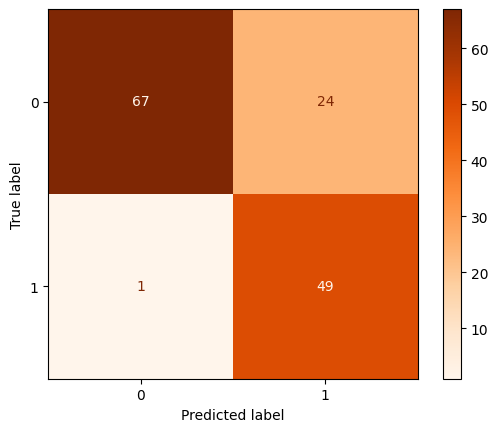

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.74      0.84        91
           1       0.67      0.98      0.80        50

    accuracy                           0.82       141
   macro avg       0.83      0.86      0.82       141
weighted avg       0.87      0.82      0.83       141

F2 Score: 0.9


In [53]:
model = xgb.XGBClassifier(scale_pos_weight = 10, learning_rate = 0.03)

model.fit(X_train4, y_train4)

y_pred = model.predict(X_valid4)

cm= confusion_matrix(y_valid4, y_pred)
class_report = classification_report(y_valid4, y_pred)
f2_score = fbeta_score(y_valid4, y_pred, beta=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()
print('Classification Report:')
print(class_report)
print(f'F2 Score: {round(f2_score,2)}')

In [54]:
model = xgb.XGBClassifier(scale_pos_weight=10, learning_rate=0.03)

cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=21)
f2_scores = cross_val_score(model, X_res3, y_res3, cv=cv, scoring=f2_scorer)

print('F2 Scores for each fold:', f2_scores)
print(f'Mean F2 Score: {np.mean(f2_scores):.2f}')

F2 Scores for each fold: [0.8778626  0.90740741 0.87686567 0.87912088 0.86142322]
Mean F2 Score: 0.88


### Oversampling + Undersampling

In [55]:
print(f'Class distribution: {Counter(y)}')

minority_class_count = Counter(y)[1]
desired_minority_class_count = minority_class_count * 2

oversampling_strategy = {1: desired_minority_class_count}

undersampling_strategy = {0: int(desired_minority_class_count * 1.5)}

oversampler = RandomOverSampler(sampling_strategy=oversampling_strategy, random_state=21)
undersampler = RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=21)

pipeline = Pipeline(steps=[('o', oversampler), ('u', undersampler)])

X_res4, y_res4 = pipeline.fit_resample(X, y)

print(f'Resampled class distribution: {Counter(y_res4)}')

Class distribution: Counter({0: 453, 1: 124})
Resampled class distribution: Counter({0: 372, 1: 248})


In [56]:
X_train5, X_valid5, y_train5, y_valid5 = train_test_split(X_res4, y_res4, test_size = 0.2, random_state = 21, stratify = y_res4)
print("Records in training dataset: ", len(X_train5))
print("Records in validation dataset: ", len(X_valid5))

Records in training dataset:  496
Records in validation dataset:  124


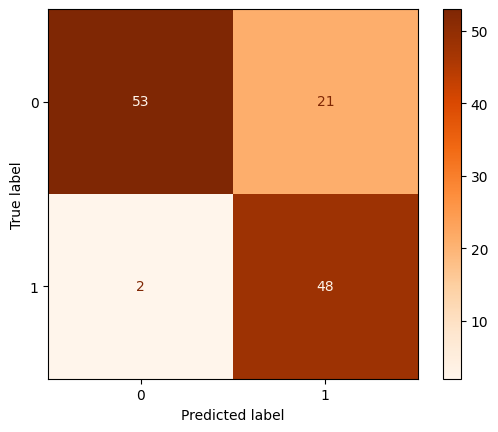

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.72      0.82        74
           1       0.70      0.96      0.81        50

    accuracy                           0.81       124
   macro avg       0.83      0.84      0.81       124
weighted avg       0.86      0.81      0.82       124

F2 Score: 0.89


In [57]:
model = xgb.XGBClassifier(scale_pos_weight = 10, learning_rate = 0.03)

model.fit(X_train5, y_train5)

y_pred = model.predict(X_valid5)

cm= confusion_matrix(y_valid5, y_pred)
class_report = classification_report(y_valid5, y_pred)
f2_score = fbeta_score(y_valid5, y_pred, beta=2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()
print('Classification Report:')
print(class_report)
print(f'F2 Score: {round(f2_score,2)}')

In [58]:
model = xgb.XGBClassifier(scale_pos_weight=10, learning_rate=0.03)

cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=21)
f2_scores = cross_val_score(model, X_res4, y_res4, cv=cv, scoring=f2_scorer)

print('F2 Scores for each fold:', f2_scores)
print(f'Mean F2 Score: {np.mean(f2_scores):.2f}')

F2 Scores for each fold: [0.91603053 0.88803089 0.9245283  0.89353612 0.93632959]
Mean F2 Score: 0.91


# Explainability

## Global Explanation

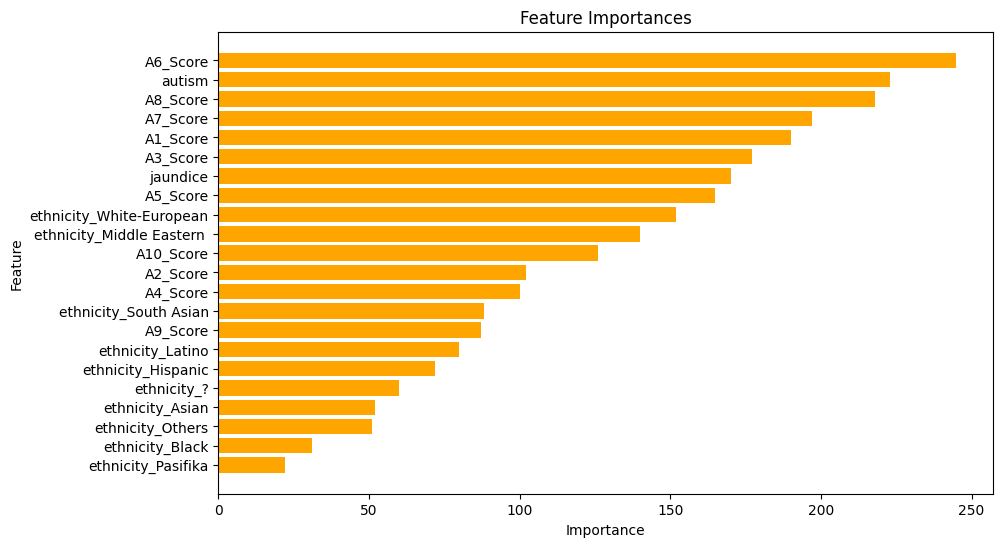

In [59]:
final_model = xgb.XGBClassifier(scale_pos_weight = 10, learning_rate = 0.03)

final_model.fit(X_train5, y_train5)

booster = final_model.get_booster()
importance = booster.get_score(importance_type='weight')

importance_df = pd.DataFrame({'Feature': list(importance.keys()), 'Importance': list(importance.values())})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='orange')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()


In [98]:
explainer = shap.Explainer(final_model)
shap_values = explainer.shap_values(X_train5)

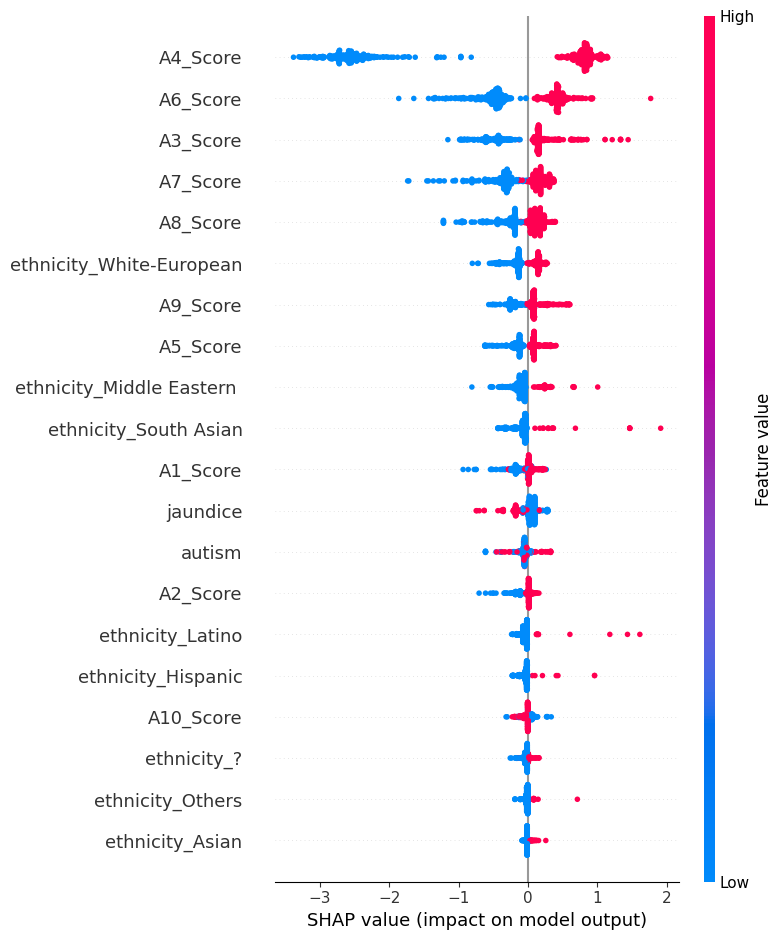

In [130]:
shap.summary_plot(shap_values, X_train5)

## Local Explanation

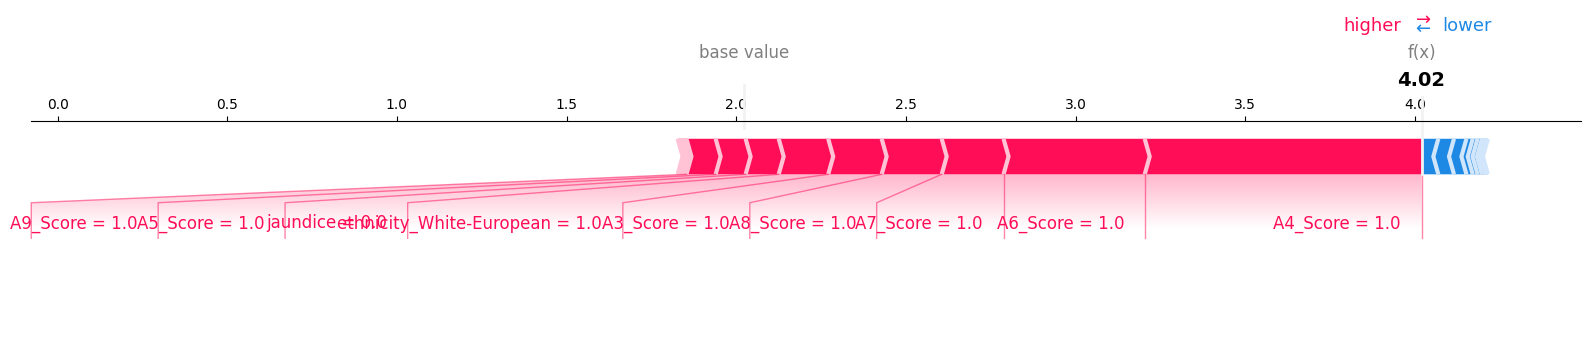

In [125]:
shap.plots.force(explainer.expected_value, shap_values[15], X_train5.iloc[15, :], matplotlib = True)

# Test set prediction

In [93]:
X_test = test_data3.drop(['Class/ASD'], axis = 1)
y_test = test_data3['Class/ASD']

In [94]:
len(y_test)

133

In [95]:
y_test_pred = final_model.predict(X_test)

In [96]:
Counter(y_test_pred)

Counter({np.int64(0): 75, np.int64(1): 58})

## References

- [1] F. Thabtah. "Autism Screening Adult," UCI Machine Learning Repository, 2017. [Online]. Available: https://doi.org/10.24432/C5F019.